<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/5: 100%|██████████| 391/391 [00:03<00:00, 125.11it/s, loss=2.59]


Epoch 1/5: Accuracy = 22.71%


Epoch 2/5: 100%|██████████| 391/391 [00:03<00:00, 128.94it/s, loss=2.49]


Epoch 2/5: Accuracy = 25.55%


Epoch 3/5: 100%|██████████| 391/391 [00:03<00:00, 115.06it/s, loss=2]


Epoch 3/5: Accuracy = 27.44%


Epoch 4/5: 100%|██████████| 391/391 [00:03<00:00, 116.13it/s, loss=2.43]


Epoch 4/5: Accuracy = 28.10%


Epoch 5/5: 100%|██████████| 391/391 [00:03<00:00, 113.06it/s, loss=2.31]


Epoch 5/5: Accuracy = 29.13%
{'units': 120, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:02<00:00, 96.14it/s, loss=2.56]


Epoch 1/5: Accuracy = 20.86%


Epoch 2/5: 100%|██████████| 196/196 [00:02<00:00, 81.75it/s, loss=2.63]


Epoch 2/5: Accuracy = 23.89%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 91.33it/s, loss=2.28]


Epoch 3/5: Accuracy = 26.56%


Epoch 4/5: 100%|██████████| 196/196 [00:02<00:00, 76.35it/s, loss=2.54]


Epoch 4/5: Accuracy = 27.05%


Epoch 5/5: 100%|██████████| 196/196 [00:02<00:00, 81.63it/s, loss=2.12]


Epoch 5/5: Accuracy = 28.88%
{'units': 120, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:02<00:00, 152.86it/s, loss=2.56]


Epoch 1/5: Accuracy = 19.94%


Epoch 2/5: 100%|██████████| 391/391 [00:02<00:00, 151.20it/s, loss=2.31]


Epoch 2/5: Accuracy = 20.73%


Epoch 3/5: 100%|██████████| 391/391 [00:02<00:00, 149.07it/s, loss=2.4]


Epoch 3/5: Accuracy = 24.33%


Epoch 4/5: 100%|██████████| 391/391 [00:02<00:00, 139.01it/s, loss=2.62]


Epoch 4/5: Accuracy = 24.84%


Epoch 5/5: 100%|██████████| 391/391 [00:02<00:00, 140.75it/s, loss=2.15]


Epoch 5/5: Accuracy = 26.45%
{'units': 120, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:01<00:00, 100.24it/s, loss=2.72]


Epoch 1/5: Accuracy = 18.29%


Epoch 2/5: 100%|██████████| 196/196 [00:01<00:00, 104.04it/s, loss=2.5]


Epoch 2/5: Accuracy = 18.78%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 86.66it/s, loss=2.29]


Epoch 3/5: Accuracy = 20.64%


Epoch 4/5: 100%|██████████| 196/196 [00:02<00:00, 88.21it/s, loss=2.43]


Epoch 4/5: Accuracy = 24.01%


Epoch 5/5: 100%|██████████| 196/196 [00:02<00:00, 97.17it/s, loss=2.34]


Epoch 5/5: Accuracy = 24.99%
{'units': 120, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:02<00:00, 140.60it/s, loss=2.82]


Epoch 1/5: Accuracy = 14.59%


Epoch 2/5: 100%|██████████| 391/391 [00:02<00:00, 139.42it/s, loss=2.71]


Epoch 2/5: Accuracy = 18.98%


Epoch 3/5: 100%|██████████| 391/391 [00:02<00:00, 134.59it/s, loss=2.44]


Epoch 3/5: Accuracy = 21.00%


Epoch 4/5: 100%|██████████| 391/391 [00:03<00:00, 122.53it/s, loss=2.65]


Epoch 4/5: Accuracy = 23.08%


Epoch 5/5: 100%|██████████| 391/391 [00:02<00:00, 134.68it/s, loss=2.57]


Epoch 5/5: Accuracy = 23.30%
{'units': 120, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:02<00:00, 93.73it/s, loss=2.87]


Epoch 1/5: Accuracy = 7.77%


Epoch 2/5: 100%|██████████| 196/196 [00:01<00:00, 98.20it/s, loss=2.66]


Epoch 2/5: Accuracy = 15.68%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 84.71it/s, loss=2.83]


Epoch 3/5: Accuracy = 18.87%


Epoch 4/5: 100%|██████████| 196/196 [00:02<00:00, 87.54it/s, loss=2.51]


Epoch 4/5: Accuracy = 21.51%


Epoch 5/5: 100%|██████████| 196/196 [00:02<00:00, 96.68it/s, loss=2.56]


Epoch 5/5: Accuracy = 22.47%
{'units': 120, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:02<00:00, 147.74it/s, loss=2.73]


Epoch 1/5: Accuracy = 12.53%


Epoch 2/5: 100%|██████████| 391/391 [00:02<00:00, 150.09it/s, loss=2.69]


Epoch 2/5: Accuracy = 16.13%


Epoch 3/5: 100%|██████████| 391/391 [00:02<00:00, 139.38it/s, loss=2.66]


Epoch 3/5: Accuracy = 19.25%


Epoch 4/5: 100%|██████████| 391/391 [00:02<00:00, 152.01it/s, loss=2.66]


Epoch 4/5: Accuracy = 21.26%


Epoch 5/5: 100%|██████████| 391/391 [00:02<00:00, 148.73it/s, loss=2.44]


Epoch 5/5: Accuracy = 22.49%
{'units': 120, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:01<00:00, 98.17it/s, loss=2.82] 


Epoch 1/5: Accuracy = 10.21%


Epoch 2/5: 100%|██████████| 196/196 [00:01<00:00, 98.37it/s, loss=2.64]


Epoch 2/5: Accuracy = 13.56%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 87.28it/s, loss=2.6]


Epoch 3/5: Accuracy = 17.41%


Epoch 4/5: 100%|██████████| 196/196 [00:01<00:00, 102.21it/s, loss=2.62]


Epoch 4/5: Accuracy = 18.50%


Epoch 5/5: 100%|██████████| 196/196 [00:01<00:00, 105.72it/s, loss=2.53]


Epoch 5/5: Accuracy = 19.99%
{'units': 120, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:03<00:00, 100.85it/s, loss=2.57]


Epoch 1/5: Accuracy = 22.86%


Epoch 2/5: 100%|██████████| 391/391 [00:04<00:00, 88.89it/s, loss=2.57]


Epoch 2/5: Accuracy = 26.39%


Epoch 3/5: 100%|██████████| 391/391 [00:04<00:00, 83.96it/s, loss=2.31]


Epoch 3/5: Accuracy = 29.06%


Epoch 4/5: 100%|██████████| 391/391 [00:04<00:00, 81.55it/s, loss=2.11]


Epoch 4/5: Accuracy = 28.80%


Epoch 5/5: 100%|██████████| 391/391 [00:04<00:00, 79.05it/s, loss=2.15]


Epoch 5/5: Accuracy = 31.73%
{'units': 240, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:02<00:00, 67.96it/s, loss=2.45]


Epoch 1/5: Accuracy = 22.22%


Epoch 2/5: 100%|██████████| 196/196 [00:02<00:00, 73.93it/s, loss=2.43]


Epoch 2/5: Accuracy = 25.55%


Epoch 3/5: 100%|██████████| 196/196 [00:03<00:00, 64.75it/s, loss=2.5]


Epoch 3/5: Accuracy = 27.59%


Epoch 4/5: 100%|██████████| 196/196 [00:03<00:00, 62.14it/s, loss=2.26]


Epoch 4/5: Accuracy = 28.86%


Epoch 5/5: 100%|██████████| 196/196 [00:03<00:00, 62.81it/s, loss=2.51]


Epoch 5/5: Accuracy = 31.12%
{'units': 240, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:03<00:00, 110.62it/s, loss=2.46]


Epoch 1/5: Accuracy = 21.34%


Epoch 2/5: 100%|██████████| 391/391 [00:03<00:00, 105.10it/s, loss=2.21]


Epoch 2/5: Accuracy = 24.29%


Epoch 3/5: 100%|██████████| 391/391 [00:03<00:00, 112.54it/s, loss=2.3]


Epoch 3/5: Accuracy = 26.19%


Epoch 4/5: 100%|██████████| 391/391 [00:03<00:00, 111.94it/s, loss=2.31]


Epoch 4/5: Accuracy = 26.98%


Epoch 5/5: 100%|██████████| 391/391 [00:03<00:00, 101.39it/s, loss=2.36]


Epoch 5/5: Accuracy = 28.45%
{'units': 240, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:02<00:00, 77.60it/s, loss=2.58]


Epoch 1/5: Accuracy = 16.67%


Epoch 2/5: 100%|██████████| 196/196 [00:02<00:00, 73.03it/s, loss=2.48]


Epoch 2/5: Accuracy = 21.87%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 75.95it/s, loss=2.36]


Epoch 3/5: Accuracy = 23.11%


Epoch 4/5: 100%|██████████| 196/196 [00:02<00:00, 68.21it/s, loss=2.3]


Epoch 4/5: Accuracy = 25.09%


Epoch 5/5: 100%|██████████| 196/196 [00:02<00:00, 73.11it/s, loss=2.43]


Epoch 5/5: Accuracy = 25.03%
{'units': 240, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:03<00:00, 102.88it/s, loss=2.75]


Epoch 1/5: Accuracy = 15.61%


Epoch 2/5: 100%|██████████| 391/391 [00:04<00:00, 97.42it/s, loss=2.45]


Epoch 2/5: Accuracy = 19.40%


Epoch 3/5: 100%|██████████| 391/391 [00:04<00:00, 93.74it/s, loss=2.55]


Epoch 3/5: Accuracy = 21.61%


Epoch 4/5: 100%|██████████| 391/391 [00:03<00:00, 99.54it/s, loss=2.49] 


Epoch 4/5: Accuracy = 23.78%


Epoch 5/5: 100%|██████████| 391/391 [00:04<00:00, 92.60it/s, loss=2.62]


Epoch 5/5: Accuracy = 23.38%
{'units': 240, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:02<00:00, 66.73it/s, loss=2.78]


Epoch 1/5: Accuracy = 15.33%


Epoch 2/5: 100%|██████████| 196/196 [00:03<00:00, 62.17it/s, loss=2.7]


Epoch 2/5: Accuracy = 17.64%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 66.74it/s, loss=2.58]


Epoch 3/5: Accuracy = 21.76%


Epoch 4/5: 100%|██████████| 196/196 [00:03<00:00, 65.23it/s, loss=2.63]


Epoch 4/5: Accuracy = 23.82%


Epoch 5/5: 100%|██████████| 196/196 [00:02<00:00, 70.13it/s, loss=2.38]


Epoch 5/5: Accuracy = 24.31%
{'units': 240, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 256}


Epoch 1/5: 100%|██████████| 391/391 [00:03<00:00, 103.95it/s, loss=2.69]


Epoch 1/5: Accuracy = 16.04%


Epoch 2/5: 100%|██████████| 391/391 [00:03<00:00, 108.44it/s, loss=2.46]


Epoch 2/5: Accuracy = 19.44%


Epoch 3/5: 100%|██████████| 391/391 [00:03<00:00, 101.34it/s, loss=2.5]


Epoch 3/5: Accuracy = 21.24%


Epoch 4/5: 100%|██████████| 391/391 [00:03<00:00, 108.45it/s, loss=2.45]


Epoch 4/5: Accuracy = 24.11%


Epoch 5/5: 100%|██████████| 391/391 [00:03<00:00, 110.14it/s, loss=2.43]


Epoch 5/5: Accuracy = 24.87%
{'units': 240, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 128}


Epoch 1/5: 100%|██████████| 196/196 [00:03<00:00, 64.41it/s, loss=2.58]


Epoch 1/5: Accuracy = 15.28%


Epoch 2/5: 100%|██████████| 196/196 [00:02<00:00, 83.89it/s, loss=2.62]


Epoch 2/5: Accuracy = 16.98%


Epoch 3/5: 100%|██████████| 196/196 [00:02<00:00, 79.02it/s, loss=2.41]


Epoch 3/5: Accuracy = 18.58%


Epoch 4/5: 100%|██████████| 196/196 [00:02<00:00, 76.78it/s, loss=2.51]


Epoch 4/5: Accuracy = 20.13%


Epoch 5/5: 100%|██████████| 196/196 [00:03<00:00, 65.02it/s, loss=2.51]


Epoch 5/5: Accuracy = 23.11%
{'units': 240, 'hidden_activations': 'sigmoid', 'loss': 'categorical_crossentropy', 'optimizer': 'adagrad', 'batch_size': 256}
Best Hyperparameter Combination: {'units': 240, 'hidden_activations': 'relu', 'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'batch_size': 128}
Best Overall Accuracy: 0.3173


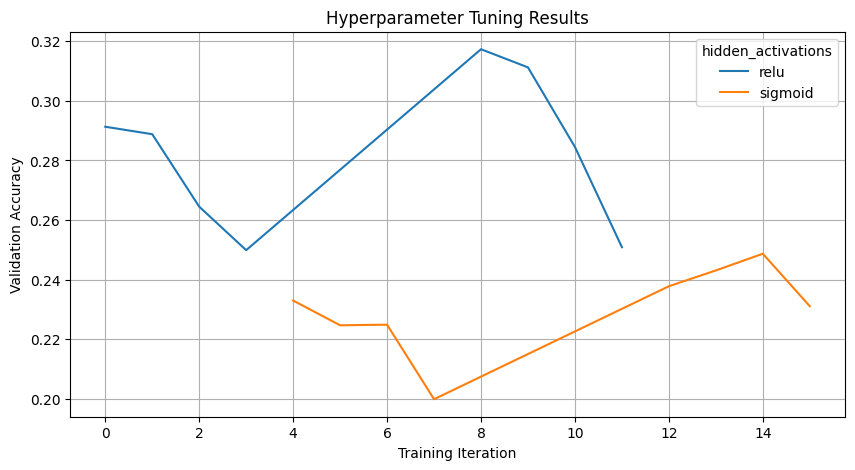

In [7]:
################################################################################
#Author: Arif H. Zaidy                                                         #
#Date: March 07, 2025                                                          #
#Course: CPSC 5440                                                             #
#Topic: Assignment 2                                                           #
#Description:                                                                  #
#This program performs hyperparameter tuning on a neural network using         #
#the CIFAR-100 dataset. It loads the dataset from Google Drive, defines        #
#a search space for hyperparameters, and trains models using different         #
#configurations. The best-performing model is selected based on validation     #
#accuracy, and results are visualized using a line plot. Finally, the script   #
#saves the results and plots to Google Drive for further analysis.             #
################################################################################

# Including Python libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from itertools import product
from tqdm import tqdm
from google.colab import drive

# Connecting to Google Drive
drive.mount("/content/drive")

# Load CIFAR-100 dataset
def load_data():
    with open('/content/drive/My Drive/train', 'rb') as file:
        train_dict = pickle.load(file, encoding='bytes')
    with open('/content/drive/My Drive/test', 'rb') as file:
        test_dict = pickle.load(file, encoding='bytes')

    X_train = train_dict[b'data']
    y_train = train_dict[b'coarse_labels']
    X_test = test_dict[b'data']
    y_test = test_dict[b'coarse_labels']

    enc = OneHotEncoder(sparse_output=False, categories='auto')
    y_train = enc.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test = enc.transform(np.array(y_test).reshape(-1, 1))

    X_train = torch.tensor(X_train / 255.0, dtype=torch.float32).reshape(-1, 3072)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test / 255.0, dtype=torch.float32).reshape(-1, 3072)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return X_train, y_train, X_test, y_test

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size=3072, hidden_size=240, num_classes=100, activation_fn=nn.ReLU):
        super(SimpleNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            activation_fn(),
            nn.Linear(hidden_size, hidden_size),
            activation_fn(),
            nn.Linear(hidden_size, num_classes)
        )
        self.history = {'epoch': [], 'accuracy': []}  # Store history in the model

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

# Train function
def train_model(X_train, y_train, X_test, y_test, params):
    model = SimpleNN(input_size=3072, hidden_size=params['units'], num_classes=100,
                      activation_fn=nn.ReLU if params['hidden_activations'] == 'relu' else nn.Sigmoid)

    criterion = nn.CrossEntropyLoss() if params['loss'] == 'categorical_crossentropy' else nn.MSELoss()
    optimizer = optim.Adam(model.parameters()) if params['optimizer'] == 'adam' else optim.Adagrad(model.parameters())

    train_loader = data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True)
    test_loader = data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=params['batch_size'], shuffle=False)

    best_acc = 0.0
    device = torch.device("cpu")
    model.to(device)

    for epoch in range(5):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/5", leave=True)

        for batch_X, batch_y in loop:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)

            if isinstance(criterion, nn.CrossEntropyLoss):
                batch_y = torch.argmax(batch_y, dim=1).long()

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(batch_y, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}/5: Accuracy = {accuracy * 100:.2f}%")

        model.history['epoch'].append(epoch)
        model.history['accuracy'].append(accuracy)

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = params

    return model, model.history, best_acc, best_params

# Define parameter grid
param_grid = {
    'units': [120, 240],
    'hidden_activations': ['relu', 'sigmoid'],
    'loss': ['categorical_crossentropy'],
    'optimizer': ['adam', 'adagrad'],
    'batch_size': [128, 256]
}

param_combinations = list(product(*param_grid.values()))

# Load data
X_train, y_train, X_test, y_test = load_data()

df_results = []
best_overall_acc = 0.0
best_hyperparams = None
for param_values in param_combinations:
    params = dict(zip(param_grid.keys(), param_values))
    _, history, acc, best_params = train_model(X_train, y_train, X_test, y_test, params)
    print(best_params)
    df_results.append({**params, 'accuracy': acc})
    if acc > best_overall_acc:
        best_overall_acc = acc
        best_hyperparams = best_params

df_results = pd.DataFrame(df_results)
print(f"Best Hyperparameter Combination: {best_hyperparams}")
print(f"Best Overall Accuracy: {best_overall_acc * 100:.2f}%")

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_results, x=df_results.index, y='accuracy', hue='hidden_activations')
plt.xlabel('Training Iteration')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Tuning Results')
plt.grid()
plt.savefig("/content/drive/My Drive/hyperparameter_tuning_plot.png", dpi=300)
plt.show()